# Economic Data Analysis using Fred API and Pandas

# Initial setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt. rcParams["axes.prop_cycle"].by_key()["color"]

# Fred API Setup 
from fredapi import Fred
import configparser
# Read hidden key
config = configparser.ConfigParser()
config.read('config.ini')

fred_key = config['credentials']['fred_key']

# 1. Create Fred object

In [2]:
fred = Fred(api_key = fred_key)

# 2. Search Economic Data

In [3]:
sp_search = fred.search('S&P', order_by = 'popularity') # sort data

In [4]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-04-02,2024-04-02,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-04-01,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-04-02 09:10:07-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-04-02,2024-04-02,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2024-01-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2024-03-26 08:11:02-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2024-04-02,2024-04-02,S&P 500,2014-04-02,2024-04-01,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-04-01 19:11:05-05:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-04-02,2024-04-02,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,83,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-04-02,2024-04-02,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-04-01,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-04-02 09:10:10-05:00,82,This data represents the effective yield of th...


# 3. Pull Raw Data & Plot

<Axes: title={'center': 'S&P 500'}>

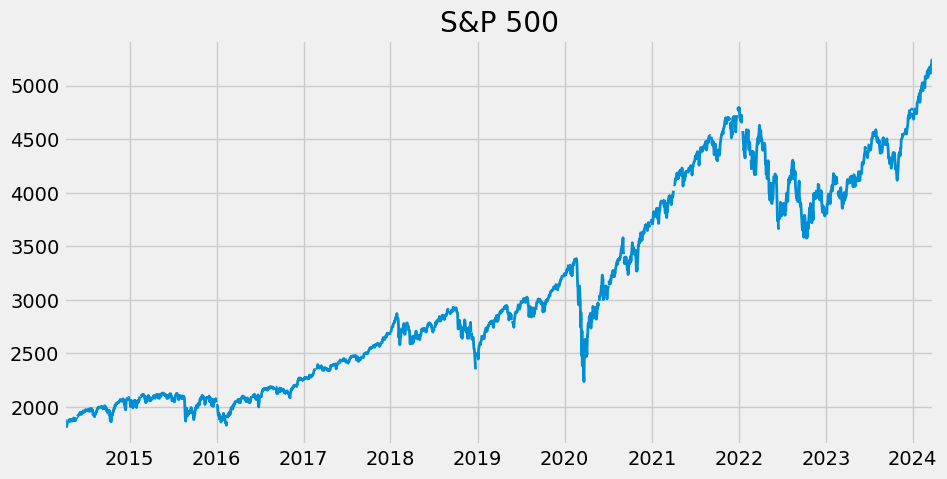

In [5]:
sp500 = fred.get_series(series_id = 'SP500') # separate data by series_id
sp500.plot(figsize = (10,5), title = 'S&P 500', lw = 2) # chart visualization 

# 4.Pull and Join Data Series

In [6]:
# Filter filters columns based on label or axis
unemp_df = fred.search('unemployment rate state', filter = ('frequency', 'Monthly'))
# Query filters rows based on boolean conditions
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
# separating by state using string filter on title
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate in')]

In [11]:
# Create list to store results
all_results = []
# Pull series data from each id
for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
# Concatenate along column
uemp_states = pd.concat(all_results, axis =1)
uemp_states = uemp_states.drop(['LASMT261982000000003', 'LASMT391746000000003'], axis = 1)
uemp_states

,CAUR,TXUR,NYUR,FLUR,PAUR,OHUR,MIUR,ALUR,MAUR,NCUR,ILUR,NJUR,GAUR,COUR,AZUR,WIUR,VAUR,KYUR,SCUR,NMUR,MNUR,TNUR,WAUR,MDUR,ORUR,WVUR,NVUR,ARUR,OKUR,MOUR,AKUR,IAUR,UTUR,PRUR,INUR,LAUR,HIUR,NDUR,MTUR,DCUR,MSUR,MEUR,NEUR,CTUR,IDUR,NHUR,RIUR,KSUR,WYUR,DEUR,VTUR,SDUR,CMWRUR,CSOUUR,CNERUR,CWSTUR,CNEWUR
1976-01-01,9.2,5.8,10.3,9.7,8.0,8.1,9.9,6.6,10.5,6.4,6.6,10.3,8.4,5.8,10.2,5.8,6.1,5.6,7.4,8.6,6.0,6.0,8.5,6.4,9.5,7.5,9.2,7.3,5.8,5.9,7.1,4.3,5.8,19.6,6.6,6.3,9.8,3.4,5.8,8.7,6.7,8.7,3.3,9.8,5.6,6.5,7.8,4.2,4.1,8.0,8.6,3.3,6.8,6.9,9.6,8.6,9.6
1976-02-01,9.2,5.8,10.3,9.7,8.1,8.1,9.9,6.6,10.5,6.4,6.6,10.3,8.4,5.7,10.2,5.8,6.1,5.6,7.4,8.7,6.0,6.0,8.5,6.4,9.5,7.5,9.2,7.3,5.8,5.9,7.1,4.3,5.9,19.5,6.6,6.3,9.8,3.4,5.8,8.7,6.7,8.7,3.3,9.8,5.6,6.5,7.8,4.2,4.1,8.0,8.6,3.3,6.8,6.9,9.6,8.6,9.6
1976-03-01,9.1,5.9,10.2,9.6,8.1,8.1,9.9,6.6,10.5,6.4,6.6,10.3,8.4,5.7,10.1,5.7,6.1,5.6,7.3,8.7,5.9,6.0,8.4,6.4,9.4,7.5,9.2,7.3,5.8,5.9,7.0,4.3,5.8,19.3,6.5,6.3,9.8,3.4,5.8,8.6,6.6,8.6,3.3,9.8,5.6,6.5,7.7,4.2,4.1,8.0,8.6,3.2,6.8,6.9,9.6,8.6,9.6
1976-04-01,9.1,5.9,10.2,9.5,8.1,8.0,9.8,6.5,10.3,6.3,6.6,10.3,8.3,5.6,10.0,5.6,6.0,5.6,7.2,8.6,5.8,6.0,8.5,6.4,9.2,7.5,9.0,7.2,5.8,6.0,6.9,4.2,5.8,19.0,6.3,6.4,9.7,3.5,5.8,8.5,6.4,8.6,3.2,9.6,5.6,6.5,7.7,4.2,4.0,8.1,8.6,3.1,6.7,6.8,9.5,8.5,9.4
1976-05-01,9.0,5.9,10.1,9.3,8.1,7.8,9.6,6.4,10.1,6.1,6.6,10.3,8.1,5.6,9.8,5.5,5.9,5.5,7.0,8.6,5.7,5.9,8.5,6.5,9.1,7.4,8.9,7.1,5.7,6.0,6.9,4.1,5.7,18.9,6.0,6.5,9.4,3.6,5.8,8.4,6.3,8.5,3.1,9.4,5.6,6.5,7.7,4.2,3.9,8.3,8.5,3.1,6.6,6.7,9.5,8.5,9.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,5.1,3.9,4.6,3.1,3.4,3.6,4.2,2.8,3.4,3.6,4.8,4.8,3.2,3.3,4.2,3.4,3.0,4.3,3.0,4.0,2.8,3.5,4.4,2.3,4.0,4.3,5.3,3.7,3.5,3.3,4.6,3.1,2.8,5.6,3.5,4.0,3.0,1.9,3.3,4.9,3.2,3.4,2.5,4.2,3.3,2.6,3.4,2.6,2.9,4.1,2.3,2.1,3.6,3.4,4.0,4.5,3.4
2023-11-01,5.1,3.9,4.6,3.1,3.4,3.6,4.1,2.8,3.3,3.6,4.7,4.8,3.2,3.3,4.2,3.4,3.1,4.3,3.0,4.0,2.7,3.5,4.4,2.2,4.0,4.3,5.3,3.7,3.5,3.3,4.6,3.1,2.8,5.6,3.5,4.0,3.0,1.9,3.3,4.9,3.2,3.4,2.5,4.2,3.3,2.6,3.4,2.6,2.9,4.1,2.3,2.1,3.6,3.4,4.0,4.5,3.4
2023-12-01,5.1,3.9,4.6,3.1,3.4,3.6,4.1,2.8,3.2,3.6,4.7,4.8,3.2,3.3,4.2,3.4,3.0,4.3,3.0,4.0,2.7,3.4,4.4,2.2,4.0,4.3,5.3,3.7,3.5,3.3,4.6,3.0,2.8,5.7,3.5,4.0,3.0,1.9,3.3,4.9,3.2,3.4,2.5,4.2,3.3,2.6,3.4,2.6,2.9,4.1,2.3,2.1,3.6,3.4,4.0,4.5,3.3
2024-01-01,5.2,3.9,4.5,3.1,3.4,3.7,4.0,2.9,3.0,3.5,4.7,4.8,3.1,3.4,4.2,3.2,3.0,4.3,3.0,4.0,2.7,3.5,4.6,2.3,4.1,4.3,5.3,3.7,3.5,3.3,4.6,3.0,2.8,5.7,3.5,4.1,3.1,1.9,3.3,5.0,3.2,3.4,2.5,4.4,3.3,2.6,3.6,2.6,2.8,4.1,2.3,2.1,3.6,3.4,4.0,4.6,3.4


In [ ]:
# Deleting missing values
uemp_states = uemp_states.dropna()

# Create dict to match state id´s to state names
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
# Replace state codes with state names using the id_to_state dictionary
uemp_states.columns = [id_to_state[col] for col in uemp_states.columns]


In [ ]:
# Plot using plotly.express
px.line(uemp_states)

## May 2020 Unemployment Rate Per State

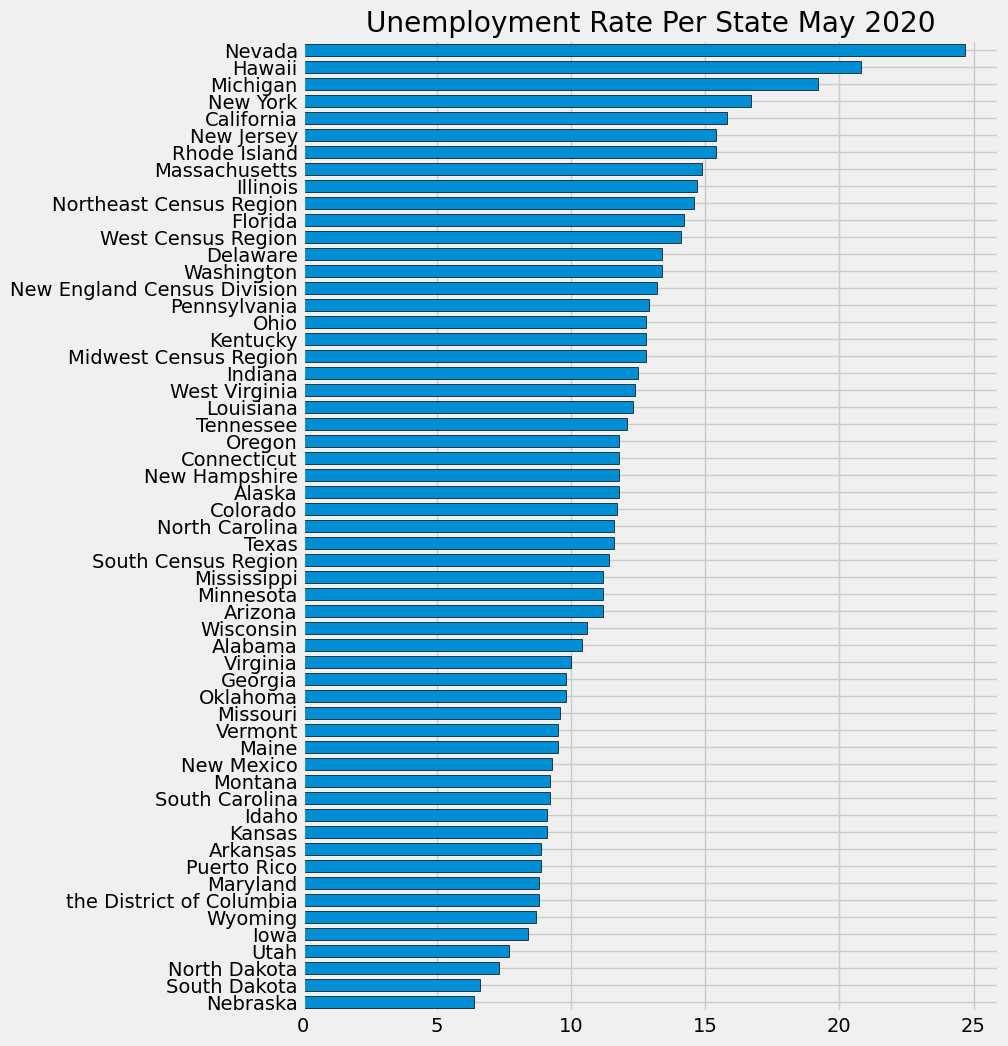

In [ ]:
# Locate where our date ocurs                                             # Transforms columns into rows
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T.sort_values('2020-05-01').plot(kind ='barh',
 figsize=(8, 12), width = 0.7, edgecolor = 'black',
 title='Unemployment Rate Per State May 2020')
ax.legend().remove()
plt.show()

# Pull participation Rate

In [ ]:
# Filter the Participation Rate by Month
part_df = fred.search('participation rate state', filter = ('frequency', 'Monthly'))
# Query  only the seasonaly adjust data
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
# Search only the Labor FOrces by state
part_df = part_df.loc[part_df['title'].str.contains('Labor Force Participation Rate for')]

In [ ]:
# Title only with State Name
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()
# Create list to store results
all_results = []
# Pull series data from each id
for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
# Concatenate along column
part_states = pd.concat(all_results, axis =1)
# Replace state codes with state names using the part_id_to_state dictionary
part_states.columns = [part_id_to_state[col] for col in part_states.columns]

# Unemployment vs Participation

/tmp/ipykernel_20665/3047897226.py:1: FutureWarning:

Starting with pandas version 3.0 all arguments of sort_values will be keyword-only.



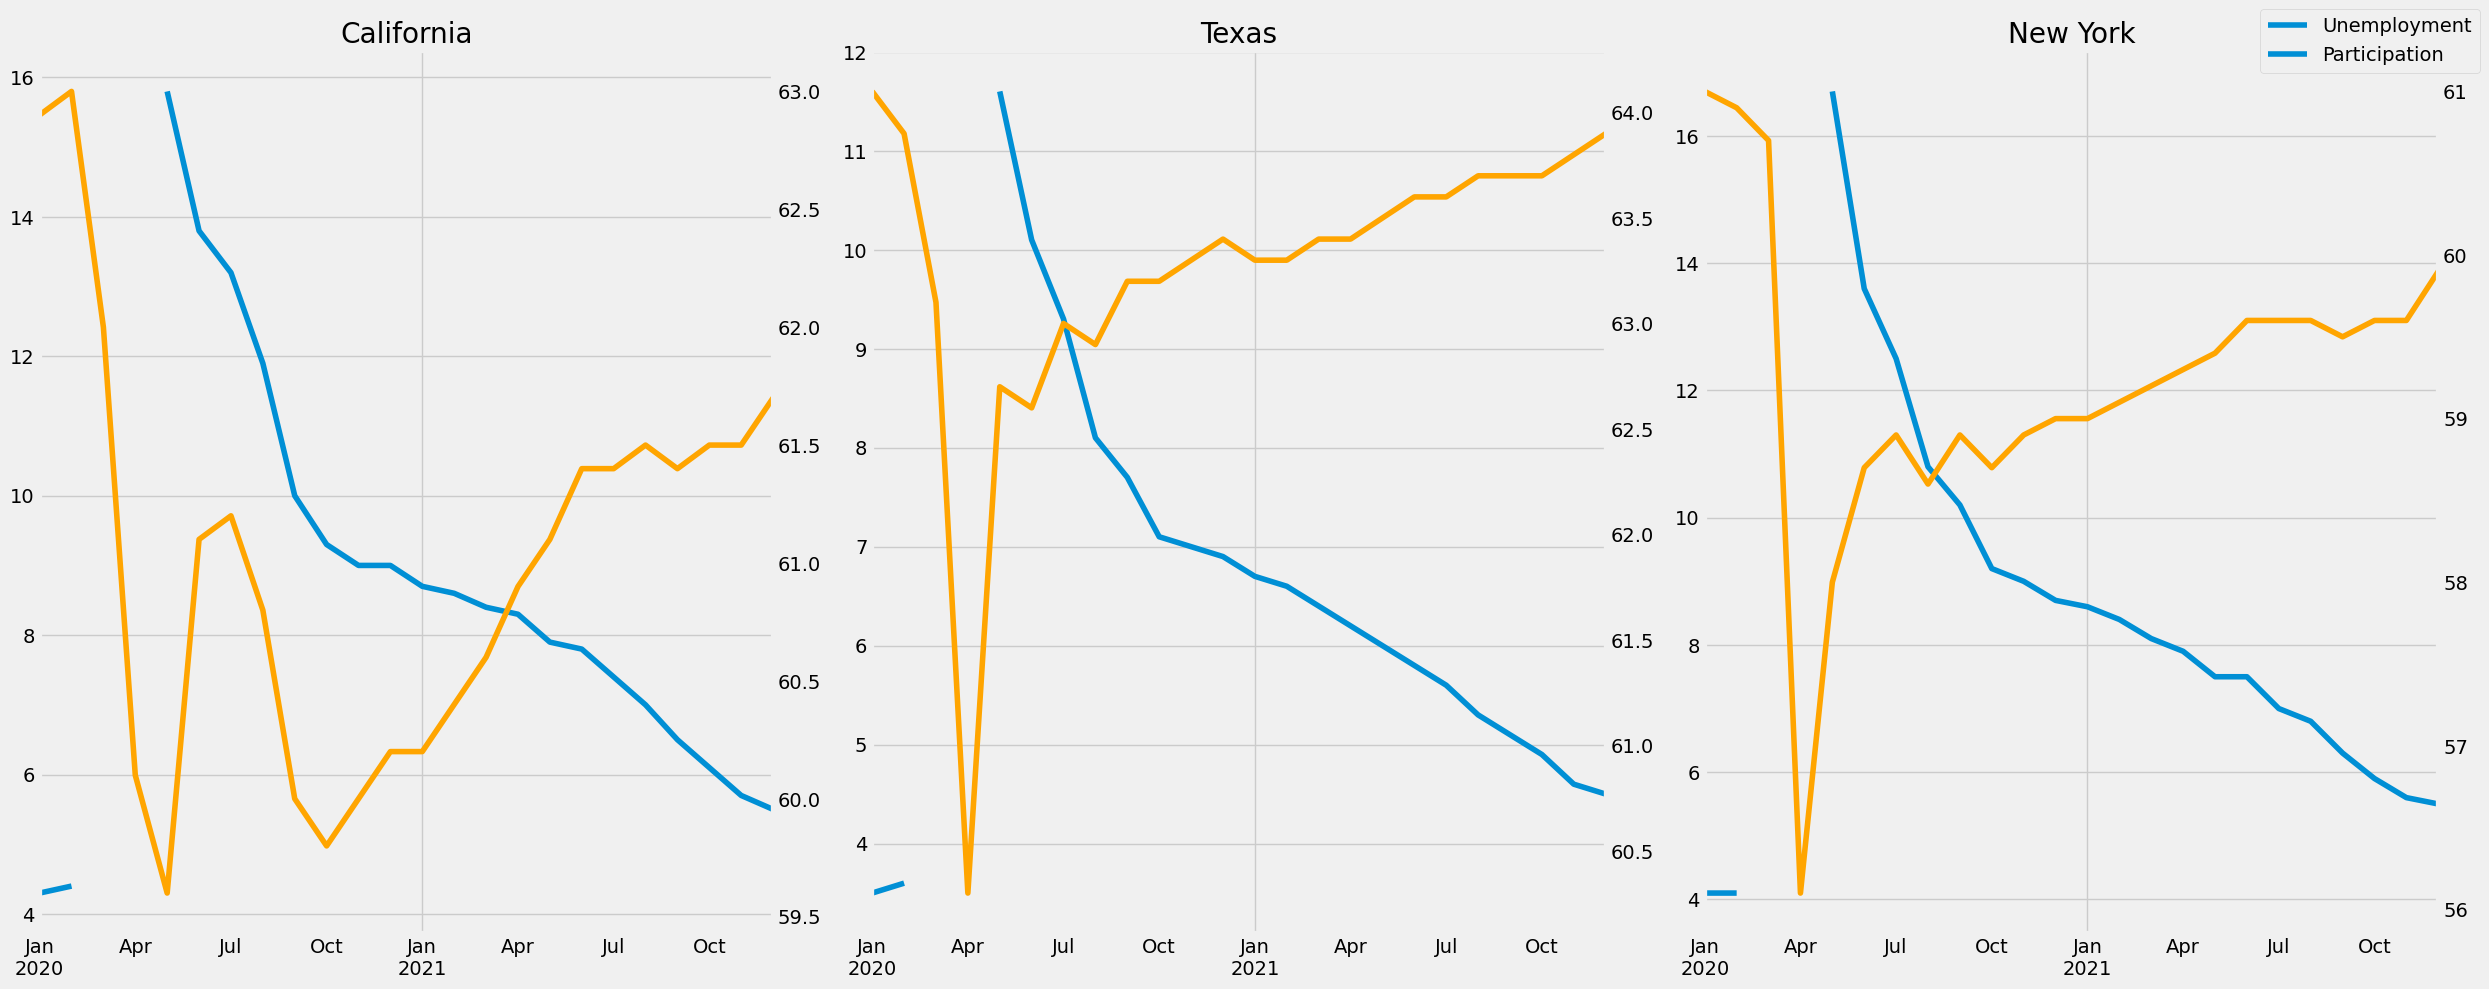

In [ ]:
uemp_states.columns.T.sort_values('2020-05-01')
# Rate comparison from 2020 to 2022
# Create a single subplot layout for all states
fig, axs = plt.subplots(1, 3, figsize=(25, 10), sharex=True)

# Iterate over the states and plot each state's comparison on its own axes
for state, ax in zip(uemp_states.columns[:3], axs):
    ax2 = ax.twinx()
    uemp_states2 = uemp_states.asfreq('MS')  # Align the data to the start of each month
    uemp_states2.query('index >= 2020 and index < 2022')[state].plot(ax=ax, label='Unemployment')
    part_states.dropna().query('index >= 2020 and index < 2022')[state].plot(ax=ax2, label='Participation', color='orange')
    ax2.grid(False)
    ax.set_title(state)

# Set common labels and legend for the entire figure
fig.legend(labels=['Unemployment','Participation'])

plt.tight_layout()
plt.show()

/tmp/ipykernel_20665/602479621.py:1: FutureWarning:

Starting with pandas version 3.0 all arguments of sort_values will be keyword-only.



KeyError: 'Northeast Census Region'

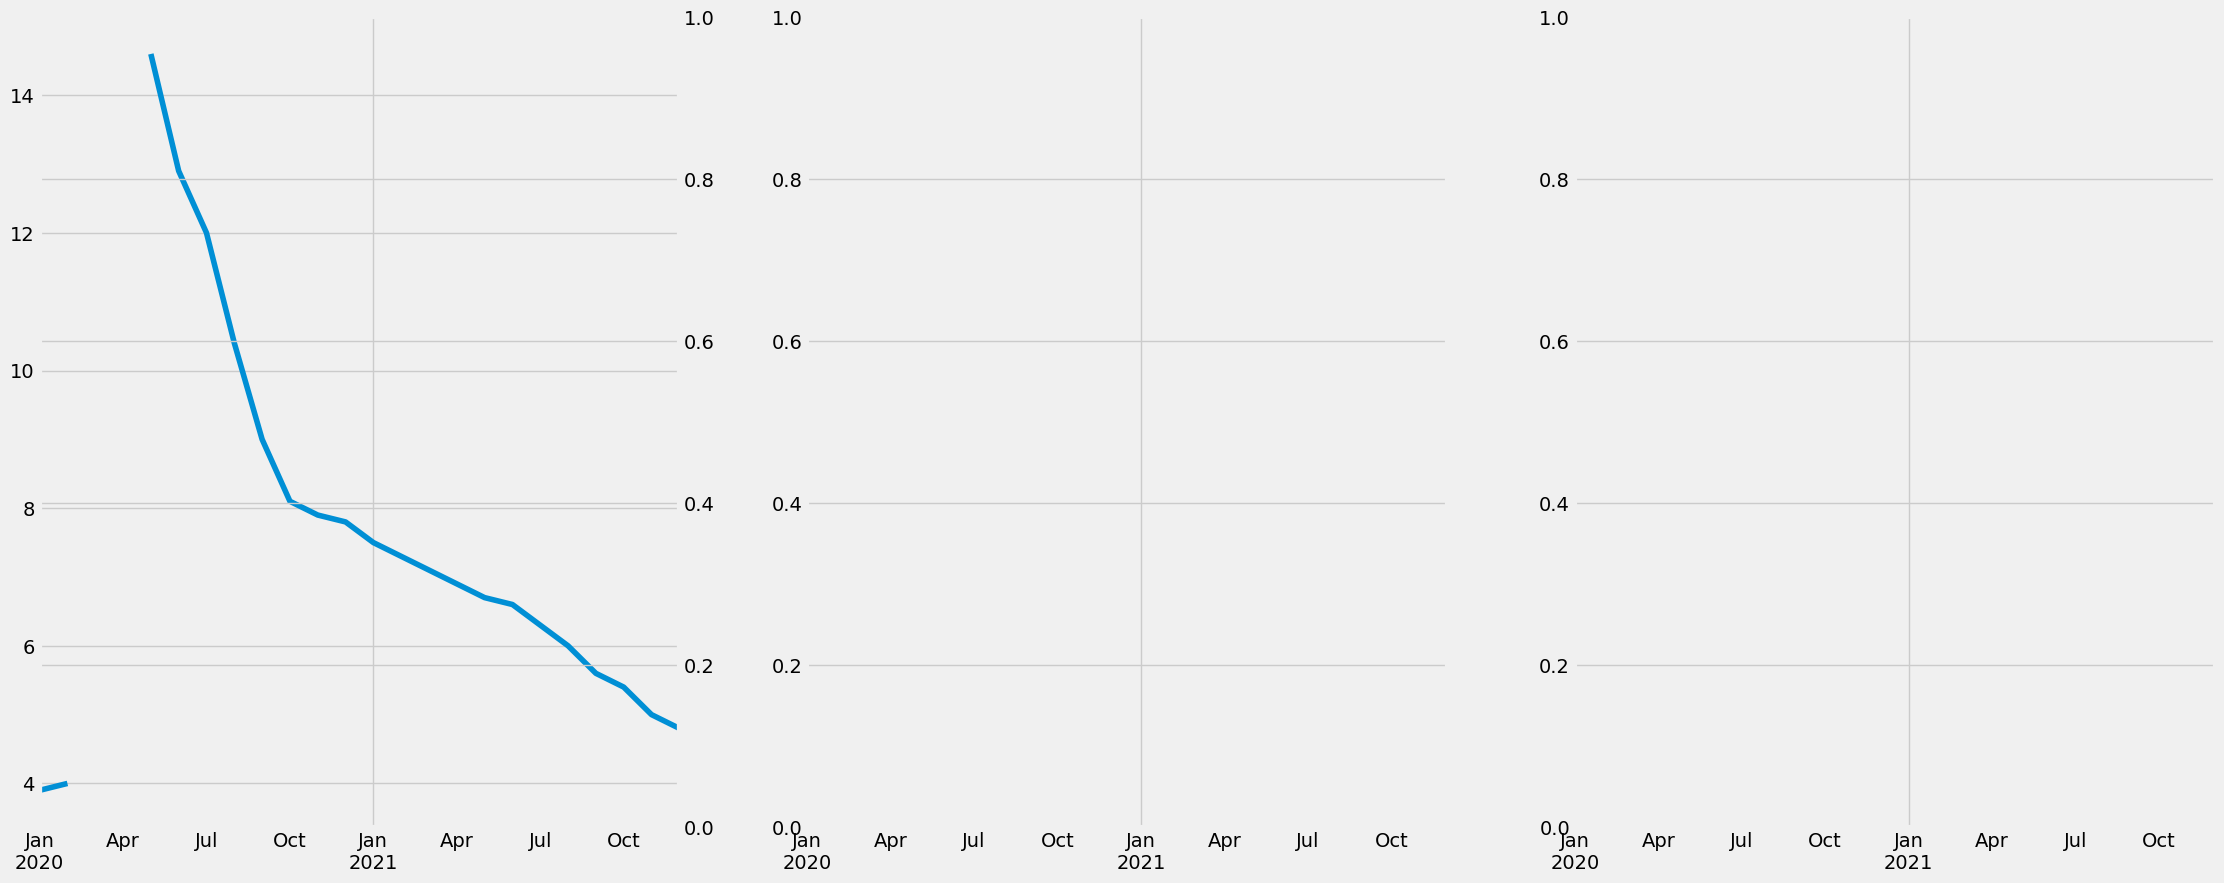

In [ ]:
uemp_states.columns.T.sort_values('2020-05-01')
# Rate comparison from 2020 to 2022
# Create a single subplot layout for all states
fig, axs = plt.subplots(1, 3, figsize=(25, 10), sharex=True)

# Iterate over the states and plot each state's comparison on its own axes
for state, ax in zip(uemp_states.columns[-3:], axs):
    ax2 = ax.twinx()
    uemp_states2 = uemp_states.asfreq('MS')  # Align the data to the start of each month
    uemp_states2.query('index >= 2020 and index < 2022')[state].plot(ax=ax, label='Unemployment')
    part_states.dropna().query('index >= 2020 and index < 2022')[state].plot(ax=ax2, label='Participation', color='orange')
    ax2.grid(False)
    ax.set_title(state)

# Set common labels and legend for the entire figure
fig.legend(labels=['Unemployment','Participation'])

plt.tight_layout()
plt.show()